In [ ]:
#!/usr/bin/env python3
# train_chess_lr.py

import chess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from matplotlib.colors import TwoSlopeNorm
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


# -------------------- Feature Extraction --------------------
def state_to_tensor(board: chess.Board) -> torch.Tensor:
    arr = torch.zeros(12 * 64, dtype=torch.float32)
    for sq, piece in board.piece_map().items():
        ch = (piece.piece_type - 1) + (0 if piece.color == chess.WHITE else 6)
        arr[ch * 64 + sq] = 1.0
    return arr


# -------------------- Load, Shuffle, Split, and Save --------------------
def load_and_split_datasets(
    train_csv, val_csv, device, train_size=100000, test_size=10000
):
    # Read and combine CSVs
    df_train = pd.read_csv(train_csv)
    df_val = pd.read_csv(val_csv)
    df_all = pd.concat([df_train, df_val], ignore_index=True)
    # Shuffle
    df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
    # Select first train_size + test_size rows
    df_sel = df_all.iloc[: train_size + test_size]
    fens = df_sel["FEN"].tolist()
    vals = df_sel["value"].values.astype(float)

    X_list, y_list = [], []
    for fen, val in tqdm(
        zip(fens, vals), total=len(fens), desc="Featurizing", unit="pos"
    ):
        board = chess.Board(fen)
        orig = state_to_tensor(board)
        factor = 32 - len(board.piece_map())
        extra = orig * factor
        feat = torch.cat([orig, extra], dim=0)
        X_list.append(feat)
        y_list.append(val)

    X = torch.stack(X_list).to(device)
    y = torch.tensor(y_list, dtype=torch.float32, device=device)

    # Split
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size : train_size + test_size]
    y_test = y[train_size : train_size + test_size]

    # Save tensors
    torch.save(X_train, "X_train.pt")
    torch.save(y_train, "y_train.pt")
    torch.save(X_test, "X_test.pt")
    torch.save(y_test, "y_test.pt")

    return X_train, y_train, X_test, y_test


# -------------------- Train Logistic Regression --------------------
def train_logistic_regression(X_train, y_train):
    X_np = X_train.cpu().numpy()
    y_np = y_train.cpu().numpy()
    lr = LogisticRegression()
    lr.fit(X_np, y_np)
    return lr


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train, X_test, y_test = load_and_split_datasets(
    "train.csv", "val.csv", device, 1_000_000, 0
)
lr_model = train_logistic_regression(X_train, y_train)

In [89]:
# -------------------- Visualize Weights --------------------
def visualize_weights(lr_model):
    # Only original 12x64 features
    weights = (lr_model.coef_[2][:768] - lr_model.coef_[0][:768]) + 3 * (
        lr_model.coef_[2][768:] - lr_model.coef_[0][768:]
    )
    # weights = (lr_model.coef_[1][:768]) + 16 * (lr_model.coef_[1][768:])
    # White channels and negated black channels
    white = weights[:384].reshape(6, 64)
    black = weights[384:768].reshape(6, 64)
    boards = np.vstack((white, black)).reshape(12, 8, 8)

    max_abs = np.max(np.abs(boards))
    norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)

    names = [
        "White Pawn",
        "White Knight",
        "White Bishop",
        "White Rook",
        "White Queen",
        "White King",
        "Black Pawn",
        "Black Knight",
        "Black Bishop",
        "Black Rook",
        "Black Queen",
        "Black King",
    ]

    files = list("abcdefgh")
    ranks = list("12345678")

    for board, name in zip(boards, names):
        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(board, cmap="RdYlGn", norm=norm, origin="lower")
        ax.set_xticks(range(8))
        ax.set_xticklabels(files)
        ax.set_yticks(range(8))
        ax.set_yticklabels(ranks)
        ax.set_xlabel("File")
        ax.set_ylabel("Rank")
        ax.set_title(name)
        fig.colorbar(im, ax=ax, shrink=0.6, orientation="vertical", label="Weight")
        plt.tight_layout()
        plt.show()

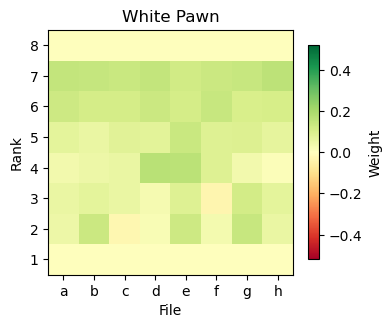

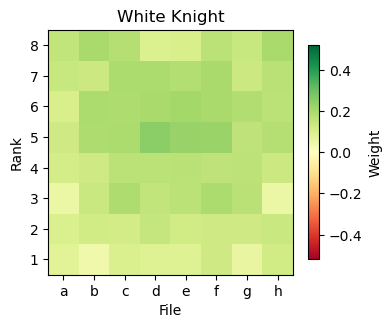

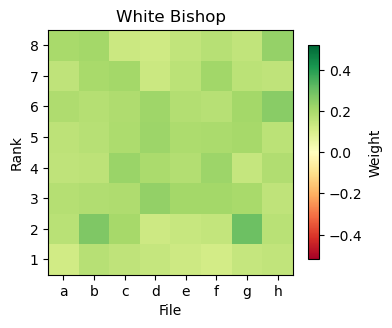

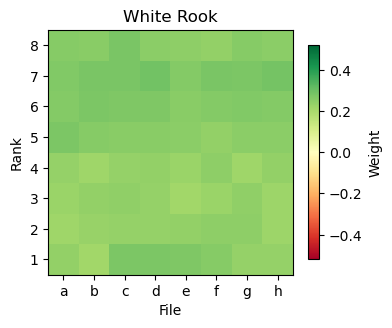

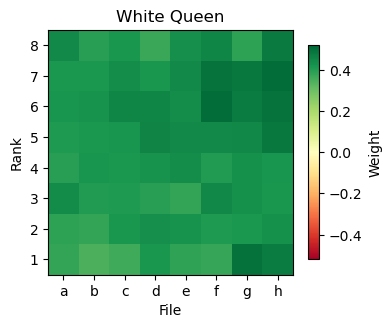

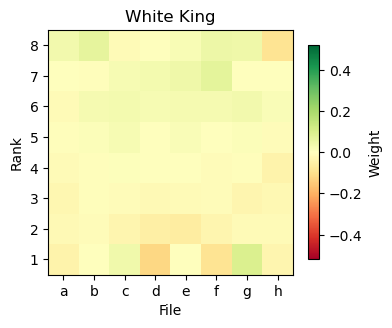

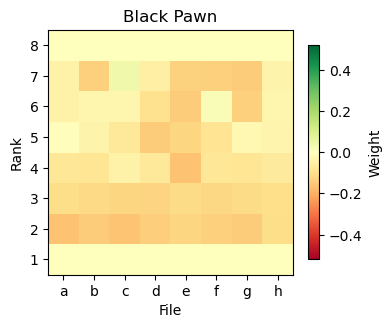

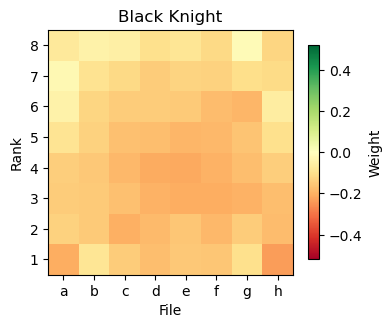

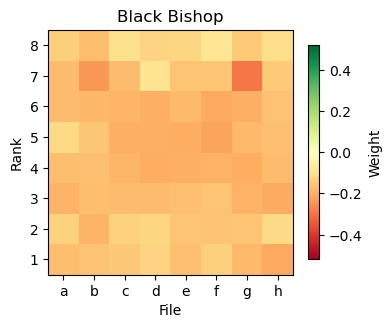

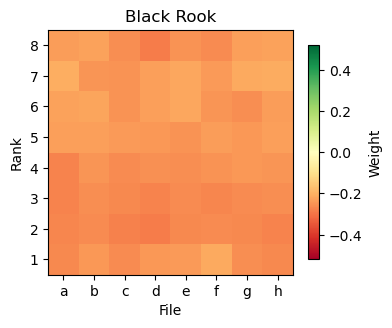

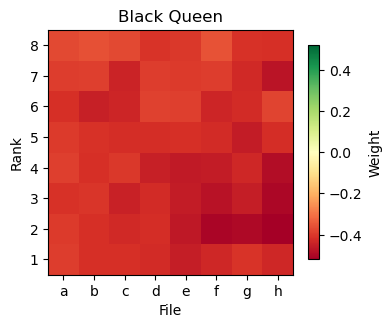

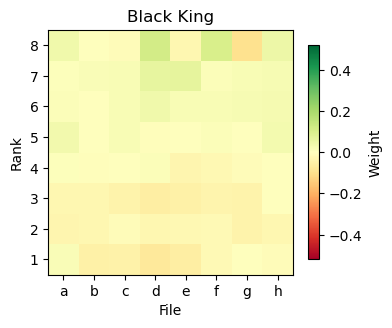

In [90]:
visualize_weights(lr_model)